# Numerical Methods 

# Chapter 7 - Gaussian Elimination, boldly into Linear Algebra!

So much of what we end up doing when we solve problems in science and engineering is taking governing ordinary or partial differential equations that describe the physics, chemistry and even biology and turning them into systems of linear, or possibly nonlinear, algebraic equations.  We need to know how to efficiently and accurately solve these linear systems of equations.  [Nonlinear equations are often solved by iterating through approximate linear systems of equations...]

Let's look at a simple example - just math.  No physics.  A three by three linear system of equations:

$$ 3 x_1 + 2 x_2 + x_3 = 6, $$
$$ -x_1 + 4 x + 5 x_3 = 8, $$
$$ 2 x_1 - 8x_2 + 10 x_3 = 4. $$

In matrix form, this is 

$$\begin{pmatrix}
3 & 2 & 1 \\
-1 & 4 & 5 \\
2 &  -8 & 10
\end{pmatrix} 
\begin{pmatrix}
x_1 \\
x_2 \\
x_3 
\end{pmatrix} =
\begin{pmatrix}
6 \\
8 \\
4 
\end{pmatrix}$$

Or, in a shorthand called *augmented matrix form*, it looks like this:

$$\begin{pmatrix}
    3 & 2 & 1 &\bigm| & 6 \\
    -1 & 4 & 5 &\bigm| & 8 \\
    2 & -8 & 10 &\bigm| & 4 
\end{pmatrix}$$

Let's store this 3 by 4 matrix for use later...

In [2]:
import numpy as np
aug_matrix = np.matrix([(3.0,2,1,6),(-1,4,5,8),(2,-8,10,4)])
print(aug_matrix)

[[ 3.  2.  1.  6.]
 [-1.  4.  5.  8.]
 [ 2. -8. 10.  4.]]


We know how to manually manipulate this system to solve it, by using the tools of elementary algebra to eliminate variables by adding and subtracting equations from each other.  

For instance, we we take the second row, and add 1/3 times the first row, we can replace the second row...

In [3]:
#add row 2 to 1/3 times row 1
row13 = aug_matrix[0]/3 #row1 * 1/3
new_row2 = aug_matrix[1] + row13 #add 1/3 row 1 to row 2
#replace row 2
aug_matrix[1,:] = new_row2
print("New matrix =\n",aug_matrix)

New matrix =
 [[ 3.          2.          1.          6.        ]
 [ 0.          4.66666667  5.33333333 10.        ]
 [ 2.         -8.         10.          4.        ]]


This eliminated $x_1$ from the second equation.   Next step:  eliminate $x_1$ from the third equation by adding -2/3 times row 1 to row 3:

In [4]:
#add row 3 to -2/3 times row 1
row23 = -2*aug_matrix[0]/3 #row1 * -2/3
new_row3 = aug_matrix[2] + row23 #add -2/3 row 1 to row 3
#replace row 3
aug_matrix[2] = new_row3
print("New matrix =\n",aug_matrix)

New matrix =
 [[ 3.          2.          1.          6.        ]
 [ 0.          4.66666667  5.33333333 10.        ]
 [ 0.         -9.33333333  9.33333333  0.        ]]


Now, eliminate $x_2$ from the third equation by adding to row 3 the quantity $\frac{(9 \frac{1}{3})}{(4 \frac{2}{3})}$ times row 1 to row3...

In [5]:
#add row 3 to 9.33333/4.66666 times row 2
modrow = (9+1./3)/(4+2./3)*aug_matrix[1] #row2 * (-9+1./3)/(4+2.0/3)
new_row3 = aug_matrix[2] + modrow #add -2/3 row 1 to row 3
#replace row 3
aug_matrix[2] = new_row3.copy()
print("New matrix =\n",aug_matrix)

New matrix =
 [[ 3.          2.          1.          6.        ]
 [ 0.          4.66666667  5.33333333 10.        ]
 [ 0.          0.         20.         20.        ]]


Our original system now has been transformed into this equivalent system:

$$\begin{pmatrix}
    3 & 2 & 1 &\bigm| & 6 \\
    0 & 4 \frac{2}{3} & 5 \frac{1}{3} &\bigm| & 10 \\
    0 & 0 & 20 &\bigm| & 20 
\end{pmatrix}$$

We can easily solve this system using *back substitution* - starting with the last row, solve each equation in succession.  In this example, solve the third equation for $x_3$, plug this into the second equation and solve for $x_2$, and then substitute $x_3$ and $x_2$ into the first equation to solve for $x_1$.

In [6]:
#backsubstitution
x3 = aug_matrix[2,3]/aug_matrix[2,2] #solve for x3
print("x3 =",x3)
#now solve for x2
x2 = (aug_matrix[1,3] - x3*aug_matrix[1,2])/aug_matrix[1,1]
print("x2 =",x2)
#now solve for x1
x1 = (aug_matrix[0,3] - x3*aug_matrix[0,2]-
x2*aug_matrix[0,1])/aug_matrix[0,0]
print("x1 =",x1)

x3 = 1.0
x2 = 1.0
x1 = 1.0


Let's check our answer but computing the residual $r = A x - b$:

In [7]:
A = np.matrix([(3.0,2,1),(-1,4,5),(2,-8,10)])
x = np.array([1,1,1])
b = np.array([6,8,4])
print(np.dot(A,x),"-",b,"=",np.dot(A,x)-b)

[[6. 8. 4.]] - [6 8 4] = [[0. 0. 0.]]


Sweet.  We did it.  This is an illustration of vanilla, no bells or whistles, Gaussian Elimination.  We can write the back substitution part very cleanly and abstractly using the following formula:

$$ x_i = \frac{1}{A_{ii}} \left( b_i - \sum\limits_{j=1+1}^{3} A_{ij} x_i \right), \qquad i=1, 2, 3$$

## Let's make a function for solving 3x3 systems using GE...


In [8]:
def GaussElim33(A,b):
    """create a Gaussian elimination matrix for a 3x3 system
    Args:
        A: 3 by 3 array
        b: array of length 3
    Returns:
        augmented matrix ready for back substitution
    """
    #create augmented matrix
    aug_matrix = np.zeros((3,4))
    aug_matrix[0:3,0:3] = A
    aug_matrix[:,3] = b
    #augmented matrix is created
    for column in range(0,3):
        for row in range(column+1,3):
            mod_row = aug_matrix[row,:]
            mod_row -= (mod_row[column]/aug_matrix[column,column]*
                        aug_matrix[column,:])
            aug_matrix[row] = mod_row
    return aug_matrix

#test function on the problem above
aug = GaussElim33(A,b)
print(aug)

[[ 3.          2.          1.          6.        ]
 [ 0.          4.66666667  5.33333333 10.        ]
 [ 0.          0.         20.         20.        ]]


And now, the back substitution...

In [9]:
def BackSub33(aug_matrix,x):
    """back substitute a 3 by 3 system after Gaussian elimination
    Args:
        aug_matrix: augmented matrix with zeros below the diagonal
        x: length 3 vector to hold solution
    Returns:
        nothing
    Side Effect:
        x now contains solution
    """
    #start at the end
    for row in [2,1,0]:
        RHS = aug_matrix[row,3]
        for column in range(row+1,3):
            RHS -= x[column]*aug_matrix[row,column]
            # Pause here to illustrate the importance of proper indention...
        x[row] = RHS/aug_matrix[row,row]
    return

x = np.zeros(3)
BackSub33(aug,x)
print("The solution is ", x)

The solution is  [1. 1. 1.]


Point of discussion: passing by reference, vs. passing by value...

Let's more rigorously test our functions: how about 100 random 3x3 systems?

In [10]:
import numpy as np
tests = 100
for i in range(tests):
    x = np.random.rand(3)
    A = np.random.rand(3,3)
    b = np.dot(A,x)
    aug = GaussElim33(A,b)
    sol = np.zeros(3)
    BackSub33(aug,sol)
    diff = np.abs(sol-x)
    try:
        assert(np.max(diff) < 1.0e-12)
    except AssertionError:
        print("Test failed with")
        print("A = ",A)
        print("x = ",x)
        raise
print("All Tests Passed!")

All Tests Passed!


## Gaussian Elimination for a General System

Would be nice to have something that worked no matter how big the linear algebra problem was, right?  I mean, do you really want to have to rewrite these functions if you have bigger or smaller matrices and vectors?  No, you don't.  Trust me.

The main change will be replace the number 3 with a variable $N$, such that our $A$ matrix is $N \times N$ and the right hand side vector $b$ is of length $N$.

In [17]:
def GaussElim(A,b):
    """create a Gaussian elimination matrix for an NxN system
    Args:
        A: N by N array
        b: array of length N
    Returns:
        augmented matrix ready for back substitution
    """
    #create augmented matrix
    [Nrow, Ncol] = A.shape
    assert Nrow == Ncol
    N = Nrow
    assert b.size == N
    aug_matrix = np.zeros((N,N+1))
    aug_matrix[0:N,0:N] = A
    aug_matrix[:,N] = b
    #augmented matrix is created
    for column in range(0,N):
        for row in range(column+1,N):
            mod_row = aug_matrix[row,:]
            mod_row -= (mod_row[column]/aug_matrix[column,column]*
                        aug_matrix[column,:])
            aug_matrix[row] = mod_row
    return aug_matrix

#let’s try it on a 4 x 4 to start
A = np.array([(3.0,2,1,1),(-1,4,5,-2),(2,-8,10,-3),(2,3,4,5)])
answer = np.arange(4)+1.0 #1,2,3,4
b = np.dot(A,answer)
aug = GaussElim(A,b)
print(aug)

[[ 3.          2.          1.          1.         14.        ]
 [ 0.          4.66666667  5.33333333 -1.66666667 18.66666667]
 [ 0.          0.         20.         -7.         32.        ]
 [ 0.          0.          0.          5.42857143 21.71428571]]


Now, let's generalize the backsubstitution function...

In [12]:
def BackSub(aug_matrix,x):
    """back substitute a N by N system after Gaussian elimination
    Args:
        aug_matrix: augmented matrix with zeros below the diagonal
        x: length N vector to hold solution
    Returns:
        nothing
    Side Effect:
        x now contains solution
    """
    N = x.size
    [Nrow,Ncol] = aug_matrix.shape
    assert Nrow+1 == Ncol
    assert N == Nrow
    #start at the end
    for row in range(N-1,-1,-1):
        RHS = aug_matrix[row,N]
        for column in range(row+1,N):
            RHS -= x[column]*aug_matrix[row,column]
            # Pause here to illustrate the importance of proper indention...
        x[row] = RHS/aug_matrix[row,row]
    return

x = np.zeros(4)
BackSub(aug,x)
print("The solution is ", x)

The solution is  [1. 2. 3. 4.]


Sweet!  We have a generic solver.  Let's do something with it!  Let's fill a large matrix with 2.01 on the diagonals, and -1 on the immediate off diagonals, and zero everywhere else, and then make a simple right hand side.


[[ 2.01 -1.    0.   ...  0.    0.    0.  ]
 [-1.    2.01 -1.   ...  0.    0.    0.  ]
 [ 0.   -1.    2.01 ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  2.01 -1.    0.  ]
 [ 0.    0.    0.   ... -1.    2.01 -1.  ]
 [ 0.    0.    0.   ...  0.   -1.    2.01]]


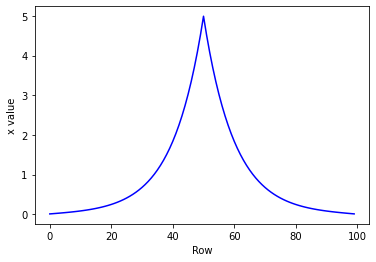

In [13]:
import matplotlib.pyplot as plt
mat_size = 100
A = np.zeros((mat_size,mat_size))
b = np.zeros(mat_size)
diag = np.arange(mat_size)
A[diag,diag] = 2.01
belowDiagRow = np.arange(1,mat_size)
A[belowDiagRow,belowDiagRow-1] = -1
aboveDiagRow = np.arange(mat_size-1)
A[aboveDiagRow,aboveDiagRow+1] = -1
print(A)

b[50] = 1
aug_mat = GaussElim(A,b)
x = np.zeros(mat_size)
BackSub(aug_mat,x)
plt.plot(diag,x,color="blue")
plt.xlabel("Row");
plt.ylabel("x value");
plt.show();

## Round off and pivoting...

When matrices have very large differences in the magnitudes of the elements, Gaussian Elimination can behave more poorly, the reason for which is the fact that digital computers use arithmetic with finite precision.  Large numbers begin divided by small numbers can lead to significant round-off error, which can propagate through all the calculations in the algorithm.  

In [14]:
epsilon = 1e-14
A = np.array([(epsilon,-1,1),(-1,2,-1),(2,-1,0)])
print(A)

[[ 1.e-14 -1.e+00  1.e+00]
 [-1.e+00  2.e+00 -1.e+00]
 [ 2.e+00 -1.e+00  0.e+00]]


In [15]:
b = np.array([0,0,1.0])
print(b)

[0. 0. 1.]


In [16]:
aug_mat = GaussElim(A,b)
x = np.zeros(3)
BackSub(aug_mat,x)
print("The solution is",x)
print("The residual is",b-np.dot(A,x))

The solution is [0.96589403 0.96969697 0.96969697]
The residual is [ 0.         -0.00380294  0.03790891]


This residual is pretty large.  Part of the reason for this is that we have not used the largest row element as the pivot element, or the element we divide by when doing the elimination. In this example, the pivot element is near zero and finite precision error is magnified when we divide by this small number.

To correct this issue we could rearrange the rows so that we divide by larger elements. This
is called *row pivoting*.

Here is another illustration of the nee for pivoting...


In [17]:
A = np.array([(1.0,0),(0,1.0)])
b = np.array([2,6.0])
print("A=\n",A)
print("b=",b)

A=
 [[1. 0.]
 [0. 1.]]
b= [2. 6.]


In [18]:
aug_mat = GaussElim(A,b)
x = np.zeros(2)
BackSub(aug_mat,x)
print(x)

[2. 6.]


Now, what if we switch the rows in A and try the same thing:

In [19]:
A = np.array([(0,1.0),(1.0,0)])
b = np.array([6.,2.0])
print("A =\n",A)
print("b =",b)
aug_mat = GaussElim(A,b)
x = np.zeros(2)
BackSub(aug_mat,x)
print("x =",x)

A =
 [[0. 1.]
 [1. 0.]]
b = [6. 2.]
x = [nan nan]


<ipython-input-11-a3bd6295e940>:21: RuntimeWarning: divide by zero encountered in double_scalars
  mod_row -= (mod_row[column]/aug_matrix[column,column]*
<ipython-input-11-a3bd6295e940>:21: RuntimeWarning: invalid value encountered in multiply
  mod_row -= (mod_row[column]/aug_matrix[column,column]*
<ipython-input-12-1fcfcb4aeeef>:21: RuntimeWarning: invalid value encountered in double_scalars
  x[row] = RHS/aug_matrix[row,row]


We naively divided by zero, since we didn't have the rows arranged to avoid that.  

To implement pivoting, we need a function that will __swap rows__ in our augmented matrix:

In [33]:
def swap_rows(A, a, b):
    """Swap two rows in a matrix: switch row a with row b
    args:
        A: matrix to perform row swaps on
        a: row index of matrix
        b: row index of matrix
    returns: nothing
    side effects:
        changes A to have rows a and b swapped
    """
    assert (a>=0) and (b>=0)
    N = A.shape[0] #number of rows
    print(N,a,b)
    assert (a<N) and (b<N) #less than because 0-based indexing
    temp = A[a,:].copy()
    A[a,:] = A[b,:].copy()
    A[b,:] = temp.copy()
    return
    
print("Before swap, A =\n",A)
swap_rows(A,0,1)
print("After swapping 0 and 1, A =\n",A)

Before swap, A =
 [[ 3.  2.  1.]
 [-1.  4.  5.]
 [ 2. -8. 10.]]
3 0 1
After swapping 0 and 1, A =
 [[-1.  4.  5.]
 [ 3.  2.  1.]
 [ 2. -8. 10.]]


In [34]:
N = 5
A = np.random.rand(N,N)
print("A =\n",A)
s = np.zeros(N)
count = 0
for row in A:
    s[count] = np.max(np.fabs(row))
    count += 1
print("s =",s)

A =
 [[0.92233285 0.1410662  0.12533039 0.88813068 0.91412634]
 [0.48369461 0.14302663 0.1020685  0.55060445 0.04308643]
 [0.39403765 0.30527947 0.05002451 0.77949647 0.73698889]
 [0.50322329 0.92055645 0.27110831 0.24376312 0.43522307]
 [0.92217935 0.23122057 0.14577537 0.92325635 0.46009466]]
s = [0.92233285 0.55060445 0.77949647 0.92055645 0.92325635]


New function - argmax: returns the index of the largest element of a vector.  

In [35]:
pivot_column = 2
largest_pos = np.argmax(np.fabs(A[:,pivot_column]/s))
print("Largest scaled element in column",
      pivot_column,"is in row",largest_pos)

Largest scaled element in column 2 is in row 3


Now can put this all together in a new version of Gaussian elimination. This function will
find the largest elements in each row of the matrix, then proceed with Gaussian elimination
where the pivot element is the element that is the largest element remaining in the
row.

In [7]:
def swap_rows(A, a, b):
    """Rows two rows in a matrix, switch row a with row b
    
    args:
        A: matrix to perform row swaps on
        a: row index of matrix
        b: row index of matrix
        
    returns: nothing
    
    side effects:
    changes A to rows a and b swapped
    """
    assert (a>=0) and (b>=0)
    N = A.shape[0] #number of rows
    assert (a<N) and (b<N) #less than because 0-based indexing
    temp = A[a,:].copy()
    A[a,:] = A[b,:].copy()
    A[b,:] = temp.copy()
    
def BackSub(aug_matrix,x):
    """back substitute a N by N system after Gaussian elimination
    
    Args:
        aug_matrix: augmented matrix with zeros below the diagonal
        x: length N vector to hold solution
    Returns:
        nothing
    Side Effect:
    x now contains solution
    """
    N = x.size
    for row in range(N-1,-1,-1):
        RHS = aug_matrix[row,N]
        for column in range(row+1,N):
            RHS -= x[column]*aug_matrix[row,column]
        x[row] = RHS/aug_matrix[row,row]
    return
def GaussElimPivotSolve(A,b,LOUD=0):
    """create a Gaussian elimination with pivoting matrix for a system
    
    Args:
        A: N by N array
        b: array of length N
    Returns:
        solution vector in the original order
    """
    import numpy as np
    [Nrow, Ncol] = A.shape
    assert Nrow == Ncol
    N = Nrow
    #create augmented matrix
    aug_matrix = np.zeros((N,N+1))
    aug_matrix[0:N,0:N] = A
    aug_matrix[:,N] = b
    #augmented matrix is created
    
    #create scale factors
    s = np.zeros(N)
    count = 0
    for row in aug_matrix[:,0:N]: #don't include b
        s[count] = np.max(np.fabs(row))
        count += 1
    if LOUD:
        print("s =",s)
    if LOUD:
        print("Original Augmented Matrix is\n",aug_matrix)
    #perform elimination
    for column in range(0,N):
        
        #swap rows if needed
        largest_pos = np.argmax(np.fabs(aug_matrix[column:N,column]/s[column])) + column
        if (largest_pos != column):
            if (LOUD):
                print("Swapping row",column,"with row",largest_pos)
                print("Pre swap\n",aug_matrix)
            swap_rows(aug_matrix,column,largest_pos)
            #re-order s
            tmp = s[column]
            s[column] = s[largest_pos]
            s[largest_pos] = tmp
            if (LOUD):
                print("A =\n",aug_matrix)
        #finish off the row
        for row in range(column+1,N):
            mod_row = aug_matrix[row,:]
            mod_row = mod_row - mod_row[column]/aug_matrix[column,column]*aug_matrix[column,:]
            aug_matrix[row] = mod_row
    #now back solve
    x = b.copy()
    if LOUD:
        print("Final aug_matrix is\n",aug_matrix)
    BackSub(aug_matrix,x)
    return x

In [8]:
#let’s try it on a 3 x 3 to start
import numpy as np
A = np.array([(3.0,2,1),(-1,4,5),(2,-8,10)])
answer = np.arange(3)+1.0 #1,2,3
b = np.dot(A,answer)
x = GaussElimPivotSolve(A,b,LOUD=1)
print("The solution is",x)
print("The residual (errors) are",np.dot(A,x)-b)

s = [ 3.  5. 10.]
Original Augmented Matrix is
 [[ 3.  2.  1. 10.]
 [-1.  4.  5. 22.]
 [ 2. -8. 10. 16.]]
Swapping row 1 with row 2
Pre swap
 [[ 3.          2.          1.         10.        ]
 [ 0.          4.66666667  5.33333333 25.33333333]
 [ 0.         -9.33333333  9.33333333  9.33333333]]
A =
 [[ 3.          2.          1.         10.        ]
 [ 0.         -9.33333333  9.33333333  9.33333333]
 [ 0.          4.66666667  5.33333333 25.33333333]]
Final aug_matrix is
 [[ 3.          2.          1.         10.        ]
 [ 0.         -9.33333333  9.33333333  9.33333333]
 [ 0.          0.         10.         30.        ]]
The solution is [1. 2. 3.]
The residual (errors) are [0.00000000e+00 0.00000000e+00 3.55271368e-15]


In [9]:
A = np.array([(0,1.0),(1.0,0)])
b = np.array([6.,2.0])
print("A =\n",A)
print("b =",b)
x = GaussElimPivotSolve(A,b,LOUD=False)
print("x =",x)
print("The residual (errors) are",np.dot(A,x)-b)

A =
 [[0. 1.]
 [1. 0.]]
b = [6. 2.]
x = [2. 6.]
The residual (errors) are [0. 0.]


## Time to Solution for Gaussian Elimination

There is a detailed discussion in McClarren on the operation count for Gaussian Elimination, and you can read that and do the math if you choose.  The upshot, though, is that GE's computational cost scales as $O(N^3)$, where $N$ is the number of unknowns in the linear system.  Let's see if we can observe this trend by running a bunch of random tests...


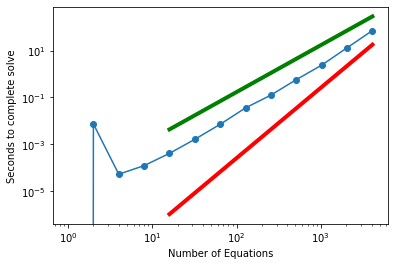

In [19]:
import time
import matplotlib.pyplot as plt
num_tests = 13
N = 2**np.arange(num_tests)
times = np.zeros(num_tests)
for test in range(1,num_tests):
    A = np.random.rand(N[test],N[test])
    b = np.dot(A,np.ones(N[test]))
    x = np.zeros(N[test])
    start = time.time()
    aug = GaussElim(A,b)
    BackSub(aug,x)
    end = time.time()
    times[test] = end-start
plt.loglog(N,times,"o-")
y_comp = times.copy()/4
for comp_place in range(num_tests-1,0,-1):
    #because x goes up by factor 2 each time, time should go up by 8
    y_comp[comp_place -1] = np.exp(np.log(y_comp[test])-3*(
        np.log(N[test])-np.log(N[comp_place-1])))
plt.loglog(N[4:num_tests],y_comp[4:num_tests],"r",linewidth=4)
#make a comparison line with slope 2
y_comp = times.copy()*4
for comp_place in range(num_tests-1,0,-1):
    y_comp[comp_place -1] = np.exp(np.log(y_comp[test])-2*(
        np.log(N[test])-np.log(N[comp_place-1])))
plt.loglog(N[4:num_tests],y_comp[4:num_tests],"g-",linewidth=4)
plt.xlabel("Number of Equations")
plt.ylabel("Seconds to complete solve")
plt.show()